In [1]:
import os, torch, torch.nn as nn, torchvision, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torchvision.io import read_image
train_folder = 'data/train/'

In [2]:
filenames=[]
for filename in os.listdir(train_folder):
    filenames.append(filename)

labels=[]
for filename in filenames:
    if filename[:3]=='dog':
        labels.append(1)
    else:
        labels.append(0)

classes={0:'cat', 1:'dog'}

filenames=filenames[:1000]
labels=labels[:1000]

# count classes in labels
from collections import Counter
Counter(labels)


Counter({1: 503, 0: 497})

/opt/homebrew/Caskroom/miniconda/base/envs/torch_ds/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


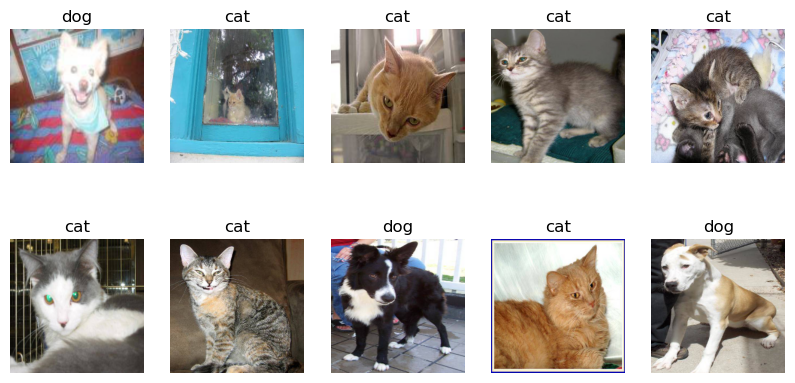

In [3]:
class CatAndDogDataset(Dataset):
    def __init__(self, filenames, labels, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image = read_image(train_folder+self.filenames[idx])
        image = image/255.0
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224))
])

sample_dataset=CatAndDogDataset(filenames[:20], labels[:20], transform=transform)
sample_dataloader=DataLoader(sample_dataset, batch_size=10, shuffle=True)

# visualize a batch of images using the dataloader
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
index=0
for xb, yb in sample_dataloader:
    for row in range(2):
        for col in range(5):
            ax[row, col].imshow(xb[row*5+col].permute(1, 2, 0))
            ax[row, col].set_title(classes[yb[row*5+col].item()])
            ax[row, col].axis('off')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42, shuffle=True)

In [5]:
class DogsAndCatsModel(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.layer1=torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout(p)
        )
        self.layer2=torch.nn.Sequential(
            torch.nn.Conv2d(32, 128, kernel_size=5, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(p)
        )
        self.layer3=torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(p)
        )

        self.fc1=torch.nn.Sequential(
            torch.nn.Linear(256*3*3, 300),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(300)
        )
        self.fc2=torch.nn.Sequential(
            torch.nn.Linear(300, 2),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, xb):
        out=self.layer1(xb)
        out=self.layer2(out)
        out=self.layer3(out)
        out=out.reshape(out.size(0), -1)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

model=DogsAndCatsModel()
model(xb).shape

torch.Size([10, 2])

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [7]:
def get_accuracy(model, loader):
    correct=0
    for xb, yb in loader:
        xb=xb.to(device)
        yb=yb.to(device)
        y_hat=model(xb)
        y_pred=torch.argmax(y_hat, dim=1)
        correct+=(y_pred==yb).sum().item()
    return correct/len(loader)

In [8]:
batch_size=128

train_dataset=CatAndDogDataset(X_train, y_train, transform=transform)
test_dataset=CatAndDogDataset(X_test, y_test, transform=transform)
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [9]:
# eigenes Modell wird erstellt
model = DogsAndCatsModel().to(device)
lr=0.01

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.6)

def train_batch(model,optimizer,  xb, yb):
    xb=xb.to(device)
    yb=yb.to(device)
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def train_epoch(model, optimizer,  x, y):
    losses=[]
    for xb, yb in train_loader:
        losses.append(train_batch(model, optimizer, xb, yb))
    return losses, get_accuracy(model, test_loader)


  0%|          | 0/20 [00:00<?, ?it/s]

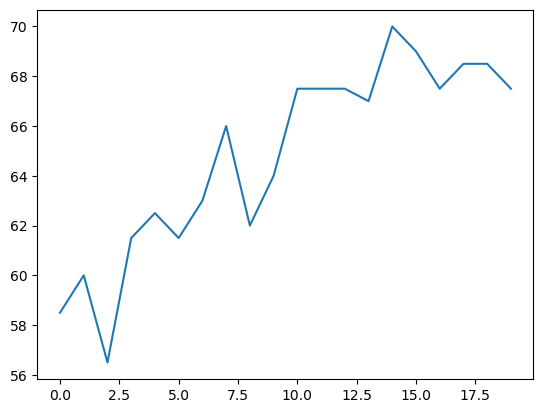

In [10]:
model = DogsAndCatsModel().to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=lr)

EPOCHS=20
accs=[]
for i in tqdm(range(EPOCHS)):
    losses, acc=train_epoch(model, optimizer, X_train, y_train)
    accs.append(acc)
plt.plot(accs)


In [11]:
accs

[58.5,
 60.0,
 56.5,
 61.5,
 62.5,
 61.5,
 63.0,
 66.0,
 62.0,
 64.0,
 67.5,
 67.5,
 67.5,
 67.0,
 70.0,
 69.0,
 67.5,
 68.5,
 68.5,
 67.5]

# Now with more transforms

In [53]:
transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((300,300)),
    torchvision.transforms.RandomCrop((224,224)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.05, hue=0.05),
    # random erasing
    torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0, inplace=False),
    torchvision.transforms.RandomRotation(degrees=10),
])

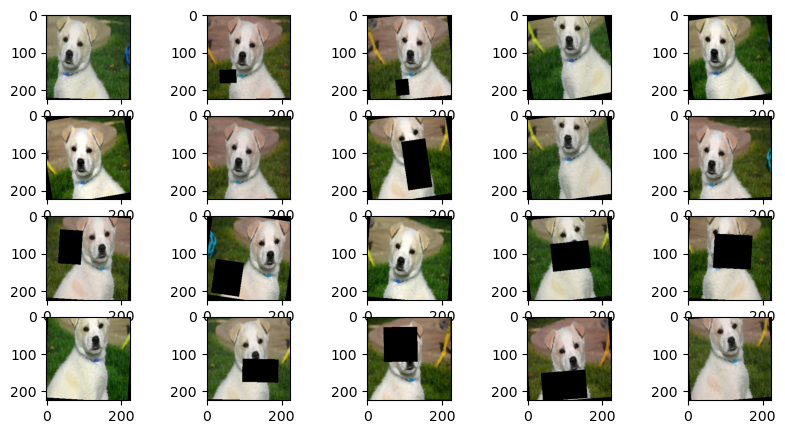

In [54]:
sample_dataset=CatAndDogDataset(filenames[31:32], labels[31:32], transform=transform)
sample_dataloader=DataLoader(sample_dataset, batch_size=10, shuffle=True)

# visualize a batch of images using the dataloader
fig, ax = plt.subplots(4, 5, figsize=(10, 5))
index=0
for i in range(20):
    xb, yb = next(iter(sample_dataloader))
    ax[i//5, i%5].imshow(xb[0].permute(1, 2, 0))


In [55]:
batch_size=128

train_dataset=CatAndDogDataset(X_train, y_train, transform=transform)
test_dataset=CatAndDogDataset(X_test, y_test, transform=transform)
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
model = DogsAndCatsModel().to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=lr)

EPOCHS=20
accs=[]
# define tqdm bar
bar=tqdm(range(EPOCHS))
for i in bar:
    losses, acc=train_epoch(model, optimizer, X_train, y_train)
    accs.append(acc)
    bar.set_description(f"Accuracy: {acc:.3f}")
plt.plot(accs) #


  0%|          | 0/20 [00:00<?, ?it/s]